In [61]:
#Total data size 19,734 X 29 

In [176]:
from math import sqrt
from numpy import concatenate

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [22,22]

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [177]:
data = read_csv('data.csv')
data.date = pd.to_datetime(data.date)
data.set_index(['date'],inplace=True)
values = data.values

In [178]:
values.shape

(19735, 28)

#### Data Preparation

In [179]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [180]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [181]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [182]:
# drop columns we don't want to predict
column_nos=range(29,56)
reframed.drop(reframed.columns[column_nos], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.428571   0.327349   0.566187   0.225345   0.684038   
2   0.046729   0.428571   0.327349   0.541326   0.225345   0.682140   
3   0.037383   0.428571   0.327349   0.530502   0.225345   0.679445   
4   0.037383   0.571429   0.327349   0.524080   0.225345   0.678414   
5   0.046729   0.571429   0.327349   0.531419   0.225345   0.676727   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var20(t-1)  \
1   0.215188   0.746066   0.351351    0.764262    ...       0.677290   
2   0.215188   0.748871   0.351351    0.782437    ...       0.678532   
3   0.215188   0.755569   0.344745    0.778062    ...       0.676049   
4   0.215188   0.758685   0.341441    0.770949    ...       0.671909   
5   0.215188   0.758685   0.341441    0.762697    ...       0.671909   

   var21(t-1)  var22(t-1)  var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)  \
1    0.372990    0.097675    0.894737    0.500000    0.953846  

### Define and fit model

In [183]:
# split into train and test sets
values = reframed.values
n_train_hours = 10000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [184]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [185]:
# reshape input to be 3D [total samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((10000, 1, 28), (10000,), (9734, 1, 28), (9734,))


In [186]:
#Designing
model= Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [187]:
#fitting the network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,validation_data=(test_X,test_y),verbose=2, shuffle=False)

Train on 10000 samples, validate on 9734 samples
Epoch 1/50
0s - loss: 0.0512 - val_loss: 0.0358
Epoch 2/50
0s - loss: 0.0404 - val_loss: 0.0309
Epoch 3/50
0s - loss: 0.0361 - val_loss: 0.0302
Epoch 4/50
0s - loss: 0.0342 - val_loss: 0.0315
Epoch 5/50
0s - loss: 0.0334 - val_loss: 0.0377
Epoch 6/50
0s - loss: 0.0361 - val_loss: 0.0437
Epoch 7/50
0s - loss: 0.0307 - val_loss: 0.0375
Epoch 8/50
0s - loss: 0.0303 - val_loss: 0.0380
Epoch 9/50
0s - loss: 0.0306 - val_loss: 0.0421
Epoch 10/50
0s - loss: 0.0309 - val_loss: 0.0393
Epoch 11/50
0s - loss: 0.0314 - val_loss: 0.0269
Epoch 12/50
0s - loss: 0.0312 - val_loss: 0.0260
Epoch 13/50
0s - loss: 0.0313 - val_loss: 0.0287
Epoch 14/50
0s - loss: 0.0311 - val_loss: 0.0257
Epoch 15/50
0s - loss: 0.0350 - val_loss: 0.0268
Epoch 16/50
0s - loss: 0.0303 - val_loss: 0.0280
Epoch 17/50
0s - loss: 0.0295 - val_loss: 0.0293
Epoch 18/50
0s - loss: 0.0295 - val_loss: 0.0310
Epoch 19/50
0s - loss: 0.0294 - val_loss: 0.0311
Epoch 20/50
0s - loss: 0.0292

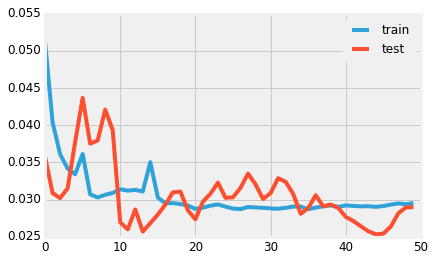

In [188]:
# plot history
%matplotlib inline
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Forecast

In [189]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) # Convert 3d to 2d

In [190]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [191]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [192]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 65.591


[]

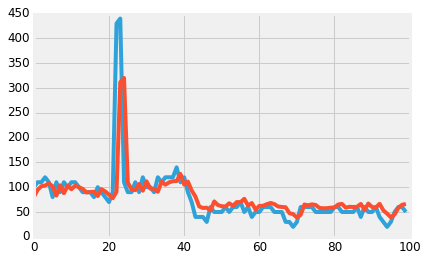

In [195]:
%matplotlib inline
plt.plot(inv_y[1500:1600])
plt.plot(inv_yhat[1500:1600])
plt.plot()

In [194]:
df = pd.DataFrame({'Actual': inv_y,'Predicted':inv_yhat})